In [20]:
import warnings
warnings.filterwarnings('ignore')

import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import cv2
import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [7]:
DIR = os.listdir('tomatoleaf/tomato/train')

In [8]:
print(DIR)

['Tomato___Late_blight', 'Tomato___healthy', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Leaf_Mold', 'Tomato___Spider_mites Two-spotted_spider_mite']


In [9]:
labels = ['Tomato___Late_blight', 'Tomato___healthy', 'Tomato___Early_blight', 
          'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 
          'Tomato___Bacterial_spot', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 
          'Tomato___Leaf_Mold', 'Tomato___Spider_mites Two-spotted_spider_mite']

In [16]:
img_size = (224, 224)

In [14]:
def load_data_from_directory(base_dir, label_list, img_size):
    """
    Loads and preprocesses images from a given directory, associating each image with a label.

    Parameters:
    base_dir (str): The base directory containing subdirectories for each label.
    label_list (list): A list of class labels.
    img_size (tuple): Desired image size for resizing (height, width).

    Returns:
    tuple: A tuple containing the images as numpy arrays and their corresponding labels.
    """
    images = []
    labels = []

    for label in label_list:
        label_path = os.path.join(base_dir, label)
        class_id = label_list.index(label)

        for img_filename in os.listdir(label_path):
            try:
                img_path = os.path.join(label_path, img_filename)
                img_data = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img_data is None:
                    print(f"Skipping {img_filename} as it could not be loaded")
                    continue

                img_resized = cv2.resize(img_data, (img_size[1], img_size[0]))  # OpenCV resize uses (width, height)
                images.append(img_resized)
                labels.append(class_id)

            except Exception as e:
                print(f"Error processing image {img_filename}: {e}")

    return np.array(images), np.array(labels)


In [17]:
train = load_data_from_directory('tomatoleaf/tomato/train/', labels, img_size)

In [18]:
validation = load_data_from_directory('tomatoleaf/tomato/val/', labels, img_size)

In [23]:

def create_dataframe(base_dir, label_list):
    """
    Creates a DataFrame containing image paths and their corresponding class labels.

    Parameters:
    base_dir (str): The base directory containing subdirectories for each label.
    label_list (list): A list of class labels.

    Returns:
    DataFrame: A DataFrame containing the image paths and their corresponding class labels.
    """
    image_paths = []
    class_labels = []

    for label in label_list:
        label_path = os.path.join(base_dir, label)
        class_id = label_list.index(label)

        for img_filename in os.listdir(label_path):
            img_path = os.path.join(label_path, img_filename)
            image_paths.append(img_path)
            class_labels.append(class_id)

    df = pd.DataFrame({
        'image_path': image_paths,
        'class_label': class_labels
    })

    df['class_label'] = df['class_label'].map(lambda x: label_list[x])

    return df

In [24]:
train_df = create_dataframe('/kaggle/input/tomatoleaf/tomato/train', labels)
train_df.head()

,image_path,class_label
0,/kaggle/input/tomatoleaf/tomato/train/Tomato__...,Tomato___Late_blight
1,/kaggle/input/tomatoleaf/tomato/train/Tomato__...,Tomato___Late_blight
2,/kaggle/input/tomatoleaf/tomato/train/Tomato__...,Tomato___Late_blight
3,/kaggle/input/tomatoleaf/tomato/train/Tomato__...,Tomato___Late_blight
4,/kaggle/input/tomatoleaf/tomato/train/Tomato__...,Tomato___Late_blight


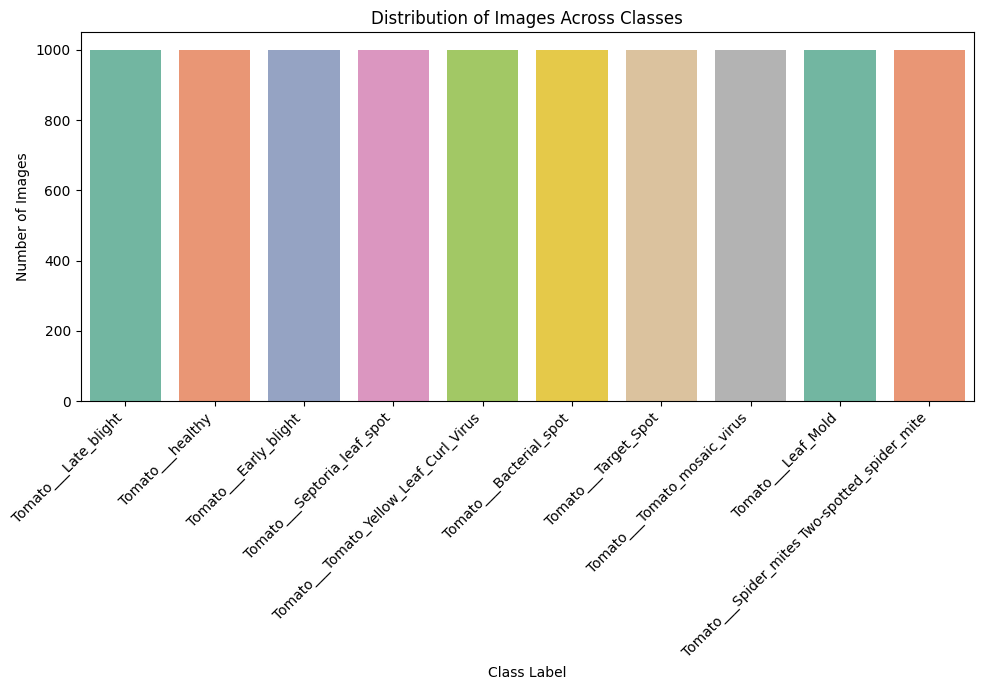

In [27]:
plt.figure(figsize=(10,7))
sns.countplot(data=train_df, x='class_label', palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Images Across Classes')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

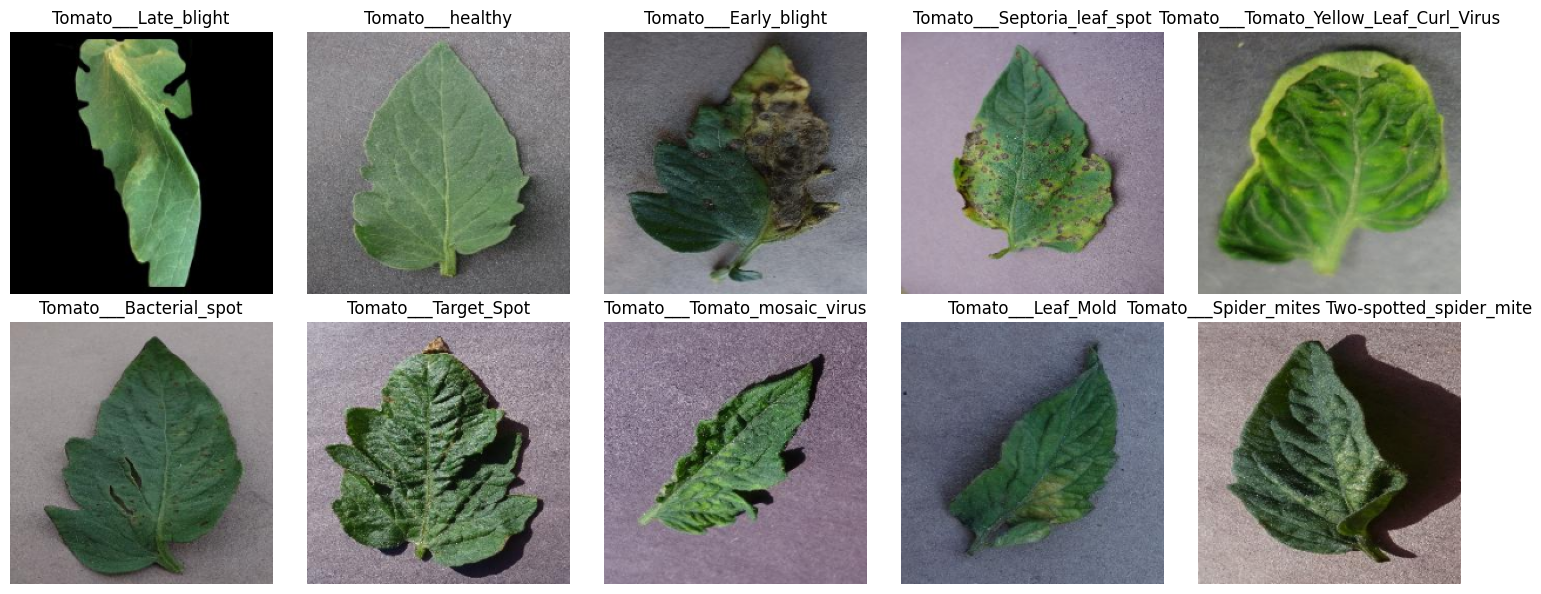

In [35]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, label in enumerate(labels):
    class_df = train_df[train_df['class_label'] == label]
    if class_df.empty:
        print(f"No images found for class label {label}. Skipping...")
        continue

    image_path = class_df.iloc[0]['image_path']
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image for class label {label} from {image_path}. Skipping...")
        continue

    img_resized = cv2.resize(img, (224, 224))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img_rgb)
    axes[i].set_title(label)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

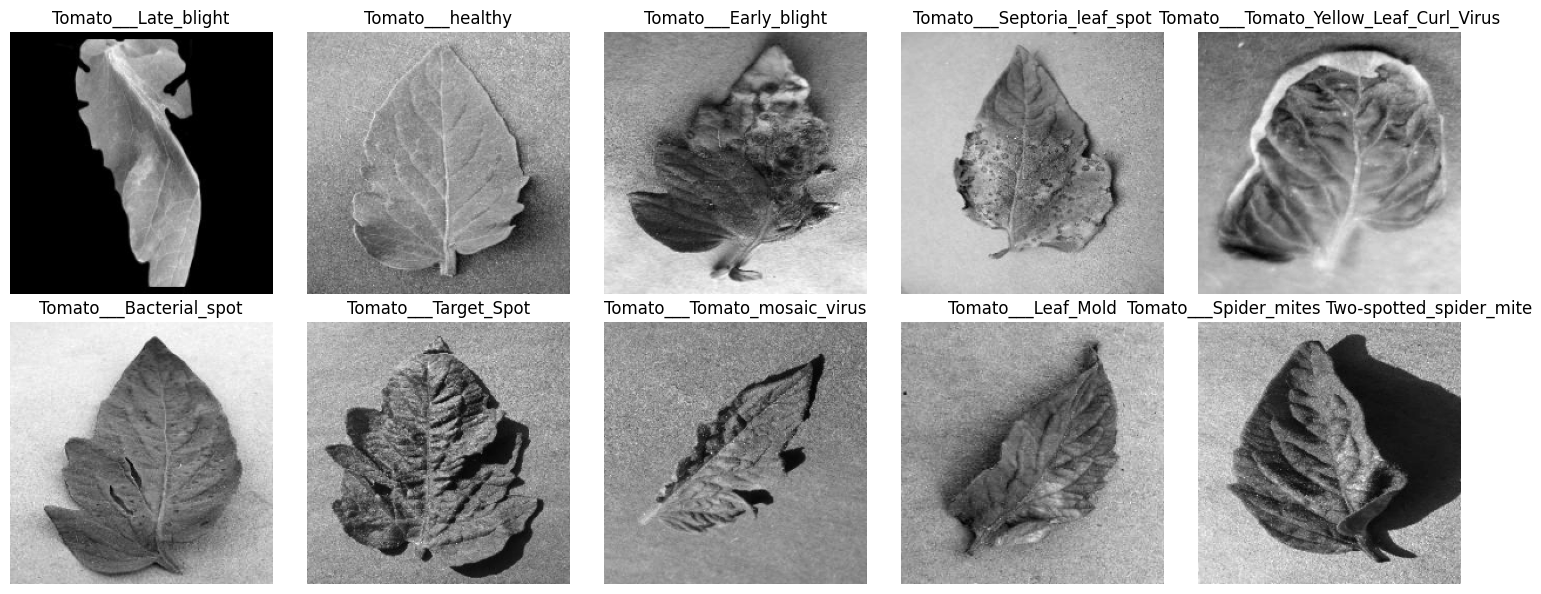

In [34]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, label in enumerate(labels):
    class_df = train_df[train_df['class_label'] == label]
    
    if class_df.empty:
        print(f"No images found for class label {label}. Skipping...")
        continue
    image_path = class_df.iloc[0]['image_path']
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image for class label {label} from {image_path}. Skipping...")
        continue

    img_resized = cv2.resize(img, (224, 224))
    axes[i].imshow(img_resized, cmap='gray')
    axes[i].set_title(label)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [36]:
x_train = []; y_train = []

x_val = []; y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in validation:
    x_val.append(feature)
    y_val.append(label)

ValueError: too many values to unpack (expected 2)